<a href="https://colab.research.google.com/github/n1az/notes_on_xai/blob/main/local_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install zennit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 926.9 kB/s eta 0:00:00


In [4]:
from itertools import islice

import torch
from torch.nn import Linear
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop
from torchvision.transforms import ToTensor, Normalize
from torchvision.models import vgg11_bn, vgg11, resnet18

from zennit.attribution import Gradient, SmoothGrad
from zennit.core import Stabilizer
from zennit.composites import EpsilonGammaBox, EpsilonPlusFlat
from zennit.composites import SpecialFirstLayerMapComposite, NameMapComposite
from zennit.image import imgify, imsave
from zennit.rules import Epsilon, ZPlus, ZBox, Norm, Pass, Flat
from zennit.types import Convolution, Activation, AvgPool, Linear as AnyLinear
from zennit.types import BatchNorm, MaxPool
from zennit.torchvision import VGGCanonizer, ResNetCanonizer

Load the Pre-trained ResNet Model:

In [2]:
import torchvision.models as models
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()  # Set the model to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 120MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Preprocess the Input Image:

In [5]:
from torchvision import transforms
from PIL import Image

torch.hub.download_url_to_file(
    'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/2006_09_06_180_Leuchtturm.jpg/640px-2006_09_06_181_Leuchtturm.jpg',
    'dornbusch-lighthouse.jpg',
)

# Define the image transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
img = Image.open("dornbusch-lighthouse.jpg")
img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

100%|██████████| 45.6k/45.6k [00:00<00:00, 1.37MB/s]


Compute the LRP-attribution using the EpsilonPlusFlat Composite:

In [14]:

# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# choose a target class for the attribution (label 437 is lighthouse)
target = torch.eye(1000)[[437]]

# create the attributor, specifying model and composite
with Gradient(model=resnet_model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(img_tensor, target)

print(f'Prediction: {output.argmax(1)[0].item()}')

Prediction: 437


Visualize the attribution:

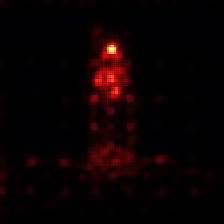

In [15]:
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')

# show the image
display(img)